# Week 10: Estimating sensitivity and bias from yes-no data

In our replication of Ringach and Shapley, we measured your psychometric function for discriminating "fat" from "thin" shapes (or in the control condition, "clockwise" from "counterclockwise" rotations). This is a "yes-no" task (single-interval, two response alternative) in which you were presented with a single stimulus and you classified it into one of two classes.

In this notebook, we're going to start looking at the data in this task from the perspective of the Equal Variance Gaussian (EVG) signal detection model. The analyses from this week onwards **should not appear in your lab report**. These notebooks are separate, to deepen your understanding of SDT.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
# set matplotlib style
matplotlib.rcParams.update({'font.size': 18})
plt.style.use('seaborn-v0_8-whitegrid')

from helpers.notebook_helper_functions import (
    plot_gaussian, 
    plot_psychometric_curve_plt,
    interactive_sdt,
    plot_dprime_plt,
)

from helpers.sdt_helper_functions import (
    summarize_hits_and_false_alarms, 
    compute_dprime, 
    compute_lambda, 
)

from helpers.psychometric_function import (
    summarize_data,
    do_fitting,
    do_curve_data, 
)

from notebook_tests.week_10_tests import *

%load_ext autoreload
%autoreload 2


## Part I: Example data

To make the notebooks easier to check, and to facilitate some additional analyses in the coming weeks, we're also going to be using the same set of example data for everyone (rather than the data you collected on your own earlier in the semester). 

This data is from one anonymous student who collected data in Wahrnehmen 2021 (used with permission).
In the 2021 year the students collected data from multiple experiments, which we're going to be looking at over the coming weeks.
For now, we select the data that corresponds to basically the same thing you did: fat/thin discrimination of illusory shapes as a function of rotation angle.

In [2]:
df = pd.read_csv("demo_data/demo_yes_no_data.csv")  # load the demo data set
# select only the trials where signal and noise were equally likely (more on that next week):
df = df.loc[df["prob_signal"] == 0.5]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   participant   1000 non-null   object 
 1   this_block    1000 non-null   int64  
 2   prob_signal   1000 non-null   float64
 3   condition     1000 non-null   object 
 4   task          1000 non-null   object 
 5   TrialNumber   1000 non-null   int64  
 6   signed_angle  1000 non-null   float64
 7   target        1000 non-null   int64  
 8   response_fat  1000 non-null   int64  
 9   hit           1000 non-null   int64  
 10  false_alarm   1000 non-null   int64  
 11  correct       1000 non-null   int64  
 12  RT            1000 non-null   float64
 13  absolute_ori  1000 non-null   float64
dtypes: float64(4), int64(7), object(3)
memory usage: 117.2+ KB


In [3]:
summary_df = summarize_data(df)
summary_df  # print result

,participant,condition,signed_angle,target,prop_fat,n_fat,n_trials,lower_ci,upper_ci
0,anon,Illusory,-2.00,0,0.013333,1,75,0.003203,0.071144
1,anon,Illusory,-1.50,0,0.146667,11,75,0.084338,0.244234
2,anon,Illusory,-1.22,0,0.216000,27,125,0.153030,0.296248
3,anon,Illusory,-1.00,0,0.333333,25,75,0.237057,0.446257
4,anon,Illusory,-0.75,0,0.240000,18,75,0.157718,0.348239
5,anon,Illusory,-0.50,0,0.360000,27,75,0.260576,0.473409
6,anon,Illusory,0.50,1,0.400000,30,75,0.296485,0.513505
7,anon,Illusory,0.75,1,0.400000,30,75,0.296485,0.513505
8,anon,Illusory,1.00,1,0.600000,45,75,0.486495,0.703515
9,anon,Illusory,1.22,1,0.824000,103,125,0.747669,0.880625


In [4]:
# run this cell to do the fitting and generate predicted psychometric function curves.
params_df = (
    summary_df.groupby(["participant", "condition"]).apply(do_fitting).reset_index()
)
curve_df = do_curve_data(params_df, ["participant", "condition"])

/var/folders/nh/282820j92l762cnqwk4bv1f80000gn/T/ipykernel_2930/568674100.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df.groupby(["participant", "condition"]).apply(do_fitting).reset_index()


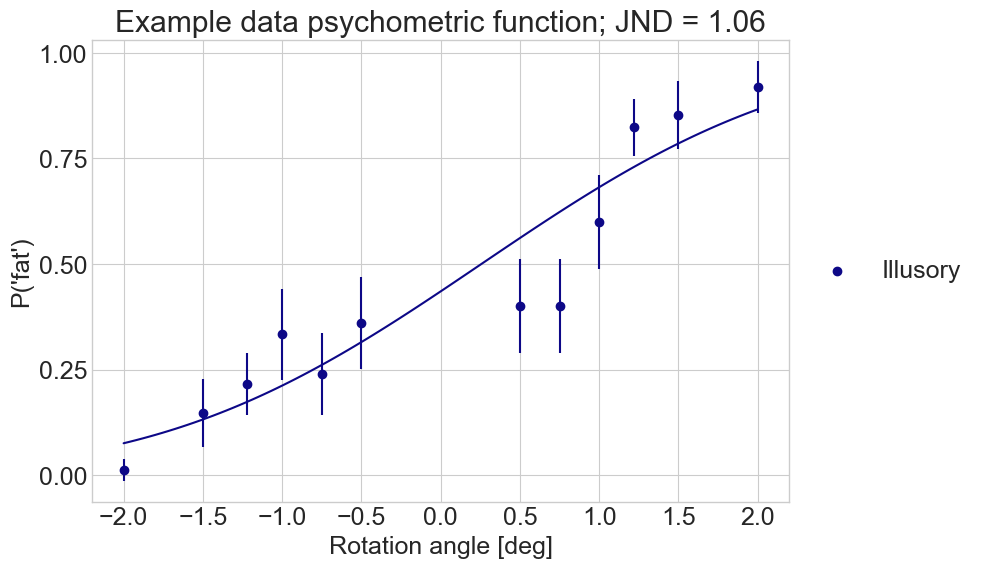

In [5]:
plot_psychometric_curve_plt(df, params_df, curve_df)
plt.show()

So you can see that this person's data likely looks similar to your own.
(If their JND seems better than your data, do not worry -- this group did the task with slightly different stimulus parameters to you, which might have made things easier).
Note that this dataset only contains data from the "Illusory" condition.

## Part II: Thinking about these data as a 2x2 outcome set

As discussed already in the `data_collection.pdf`, we can think about the data in *each* level of *absolute* angle offset from the perspective of the 2x2 outcome matrix familiar to you from the SDT lectures:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">"Yes" response</th>
    <th class="tg-0pky">"No" response</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">Signal</td>
    <td class="tg-0pky">Hit</td>
    <td class="tg-0pky">Miss</td>
  </tr>
  <tr>
    <td class="tg-0pky">Noise</td>
    <td class="tg-0pky">False Alarm</td>
    <td class="tg-0pky">Correct Rejection</td>
  </tr>
</tbody>
</table>

Translating this into our task, treating "fat" shapes (positive rotation angles) as "signal" and "thin" shapes (negative rotation angles) as "noise", we have:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">"fat" response</th>
    <th class="tg-0pky">"thin" response</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">Angle &gt; 0 ("fat")</td>
    <td class="tg-0pky">Hit</td>
    <td class="tg-0pky">Miss</td>
  </tr>
  <tr>
    <td class="tg-0pky">Angle &lt; 0 ("thin")</td>
    <td class="tg-0pky">False Alarm</td>
    <td class="tg-0pky">Correct Rejection</td>
  </tr>
</tbody>
</table>

Hopefully you can see that the logic here is the same, and that the assignment to "signal" and "noise" doesn't matter.

The demo dataset already contains columns defining whether each trial was a "hit" or a "false alarm". Look at the print out below and verify that you understand these values:

In [6]:
df.loc[df["absolute_ori"] == 0.5].head(10)

,participant,this_block,prob_signal,condition,task,TrialNumber,signed_angle,target,response_fat,hit,false_alarm,correct,RT,absolute_ori
300,anon,13,0.5,Illusory,yes-no,1,-0.5,0,0,0,0,1,0.352717,0.5
301,anon,13,0.5,Illusory,yes-no,2,0.5,1,0,0,0,0,0.233136,0.5
302,anon,13,0.5,Illusory,yes-no,3,0.5,1,1,1,0,1,0.617536,0.5
303,anon,13,0.5,Illusory,yes-no,4,0.5,1,1,1,0,1,0.290825,0.5
304,anon,13,0.5,Illusory,yes-no,5,-0.5,0,1,0,1,0,0.393998,0.5
305,anon,13,0.5,Illusory,yes-no,6,-0.5,0,0,0,0,1,0.217328,0.5
306,anon,13,0.5,Illusory,yes-no,7,0.5,1,0,0,0,0,0.729963,0.5
307,anon,13,0.5,Illusory,yes-no,8,-0.5,0,1,0,1,0,0.330455,0.5
308,anon,13,0.5,Illusory,yes-no,9,-0.5,0,0,0,0,1,0.274795,0.5
309,anon,13,0.5,Illusory,yes-no,10,0.5,1,0,0,0,0,0.302452,0.5


### <span style="color:blue">Task 1</span>

Open the file `sdt_helper_functions.py` in the `/notebooks` directory using either the Jupyter notebook browser, a text editor, or an IDE like VS Code.

Part of this file defines a function called `summarize_hits_and_false_alarms`. 
Currently, this function body just contains `pass`.

Your first task is to fill in the function body of `summarize_hits_and_false_alarms` so that it will create a summarized data frame containing hit and false alarm rates.

Using the Pandas `groupby` and `agg` functions, split the data by the variables `absolute_ori`.
Compute seven new variables in each grouping level combination: 

- `n_hit`
- `n_fa`
- `n_signal`
- `n_noise`
- `proportion_correct`
- `hit_rate`
- `false_alarm_rate`

Remember: call `reset_index()` on the summary dataframe at the end (e.g. as the last method in a chain) to remove Pandas multiindexing and get back all variables as simple columns.

#### Hints

- the `hit_rate` and `false_alarm_rate` variables depend on some of the other new variables you're going to compute with `agg`. You should run the call to `agg` first, then compute `hit_rate` and `false_alarm_rate`.
- you can use the `assign` method to assign new variables to a data frame in a chain.

There is a cell of tests below; make sure your data passes these tests with no `AssertionError`s before continuing.

In [7]:
hit_fa_df = summarize_hits_and_false_alarms(df, groups=["absolute_ori"])
hit_fa_df

,absolute_ori,n_hit,n_fa,n_signal,n_noise,proportion_correct,hit_rate,false_alarm_rate
0,0.50,30,27,75,75,0.078,0.400000,0.360000
1,0.75,30,18,75,75,0.087,0.400000,0.240000
2,1.00,45,25,75,75,0.095,0.600000,0.333333
3,1.22,103,27,125,125,0.201,0.824000,0.216000
4,1.50,64,11,75,75,0.128,0.853333,0.146667
5,2.00,69,1,75,75,0.143,0.920000,0.013333


In [8]:
# tests of the function -- do not modify this cell
test_summarize_hits_and_false_alarms_1(hit_fa_df)

Now we have the information we need (hit and false alarm rates) to compute sensitivity (here, $d^\prime$) and criterion ($\lambda$) assuming the Equal Variance Gaussian SDT model.

To do that, you can use the Normal (Gaussian) probability distribution functions that you learned about in `homework_3_experiment_analysis_1`.
To remind you:

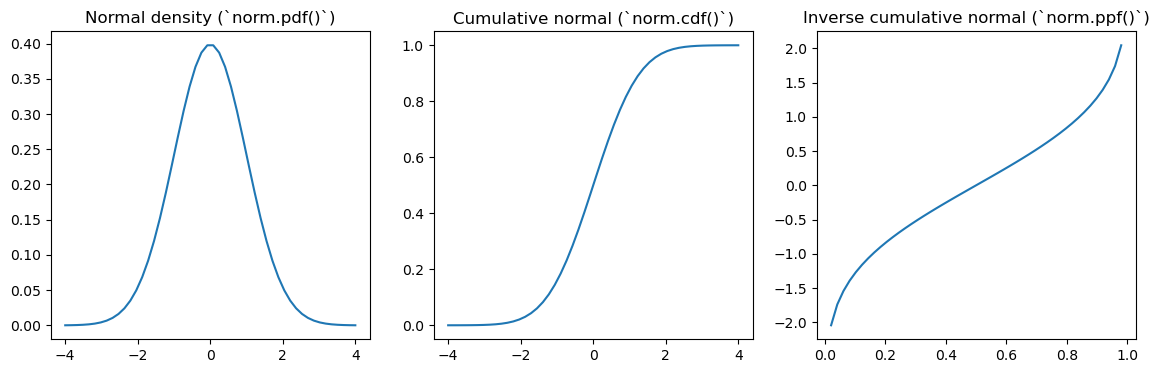

In [9]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plot_gaussian()

### <span style="color:blue">Task 2</span>

Following the formulae outlined in the SDT lecture (see slides 35-36), compute sensitivity (here, $d^\prime$) and criterion $\lambda$ for each absolute orientation value, by filling in the functions `compute_dprime` and `compute_lambda` in the file `sdt_helper_functions.py`.

In [10]:
# you could use this cell to try out functions.

Run the cell below to test your functions. If running the cell creates assertion errors, then your functions are not working properly yet.
Note that cell will fail at the *first* error it encounters -- which means there could be more problems further on.
Keep re-writing your functions and running the cell below until you see no errors.
(Remember: you need to re-run the cell above every time you change the code, in order to redefine the function).

In [11]:
# do not modify this cell!
test_dprime(compute_dprime)
test_lambda(compute_lambda)

In [12]:
hit_fa_df = hit_fa_df.assign(dprime=compute_dprime, criterion=compute_lambda)
hit_fa_df

,absolute_ori,n_hit,n_fa,n_signal,n_noise,proportion_correct,hit_rate,false_alarm_rate,dprime,criterion
0,0.50,30,27,75,75,0.078,0.400000,0.360000,0.105112,0.358459
1,0.75,30,18,75,75,0.087,0.400000,0.240000,0.452955,0.706303
2,1.00,45,25,75,75,0.095,0.600000,0.333333,0.684074,0.430727
3,1.22,103,27,125,125,0.201,0.824000,0.216000,1.716491,0.785774
4,1.50,64,11,75,75,0.128,0.853333,0.146667,2.101675,1.050837
5,2.00,69,1,75,75,0.143,0.920000,0.013333,3.621434,2.216363


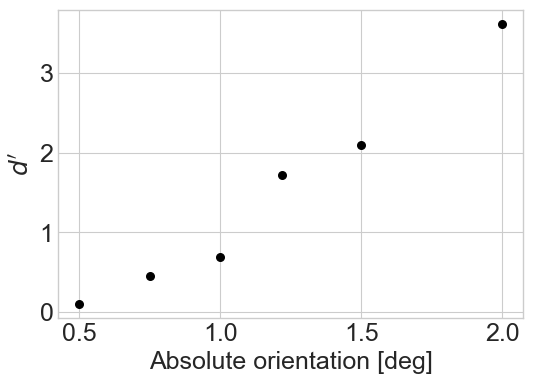

In [13]:
# set matplotlib style
matplotlib.rcParams.update({"font.size": 18})
plt.style.use("seaborn-v0_8-whitegrid")

# do the plot
plot_dprime_plt(hit_fa_df)
plt.show()

### Interactive SDT plot

To give you better intuitions about what these values mean, here's an interactive SDT plot. 
You can play around with the values to match those in the table above.

In [14]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

interactive_sdt()

interactive(children=(FloatSlider(value=2.0, description='d_prime', max=4.0, min=-3.0), FloatSlider(value=1.0,…

### <span style="color:blue">Task 3</span>

In the Markdown cell below, describe the relationship between $d^\prime$ and absolute orientation (how are they related, and what does this mean?).

Also consider what the bounds for $d^\prime$ are. What does $d^\prime = 0$ mean? What do higher values mean? What would a negative value of $d^\prime$ mean?

*If d' is eqaul 0, then the observer can not discriminate between signal and noise, the bigger the absolute orientation gets, the bigger becomes the sensitivity.*
*If d' was negative it would mean that the observer confuses signal with noise.*

